# Chapter 2
+ 아래로 내려가면서 구현
+ 다 구현되면 .py 파일로 모듈화

### mlfinlab
+ https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/data_structures/base_bars.py
+ https://github.com/hudson-and-thames/mlfinlab/blob/master/mlfinlab/data_structures/imbalance_data_structures.py

### BlackArbsCEO/Adv_Fin_ML_Exercises
+ https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/src/features/bars.py

In [33]:
# from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
'''
symbol = 'ES=F'
f = open("ALPHA_KEY", 'r')
key = f.readline()
f.close()
# AlphaVantage에서 데이터를 받아온다.
ts  = TimeSeries(key=key, output_format='pandas')
tmp, meta_tmp = ts.get_intraday(symbol=symbol,interval='1min', outputsize='full')
tmp.index = pd.to_datetime(tmp.index)
## -> tick data 아님
'''

# 틱 데이터
path = 'MiniKospi/'
# 파일명이 일관성이 있으며 시간순으로 오름차순이어야함. 
# 아니면 별도의 sort 또는 예외처리를 해야한다. 
list_file = os.listdir(path)
list_file.sort()
display(list_file)

data = pd.DataFrame(columns=['close','volume']) 
data.index.names = ['timestamp']
cnt=0


# 일단은 전체 데이터를 하나의 dataframe이 넣어서 돌리자
# 메모리 이슈 생각하면 파일을 쪼개서 하나씩 처리해야 하지만, 아직은 데이터 셋이 그렇게 크지 않음
# 다만 항상 분할해서 처리해야함을 염두해 두자.
for file in list_file :
    cnt+=1
    print('reading ' + path + file + ' ' + str(cnt) +'/' + str(len(list_file)) )
    tmp = pd.read_csv(path+file,index_col=0)
    tmp = tmp.drop(columns=['date','time','sell','buy'])
    # conver to datetime
    tmp.index = pd.to_datetime(tmp.index)
    tmp.index.names = ['timestamp']
    data = data.append(tmp)
    # display(tmp.head())
    # 일단 2개만.
# display
display(data.head())
display(data.tail())

['181122-1219.csv',
 '181220-1231.csv',
 '190101-0117.csv',
 '190118-0131.csv',
 '190201-0217.csv']

reading MiniKospi/181122-1219.csv 1/5
reading MiniKospi/181220-1231.csv 2/5
reading MiniKospi/190101-0117.csv 3/5
reading MiniKospi/190118-0131.csv 4/5
reading MiniKospi/190201-0217.csv 5/5


,close,volume
timestamp,,
2018-11-22 09:00:00,268.559998,29.0
2018-11-22 09:00:00,268.600006,1.0
2018-11-22 09:00:00,268.579987,1.0
2018-11-22 09:00:00,268.660004,1.0
2018-11-22 09:00:00,268.619995,1.0


,close,volume
timestamp,,
2019-02-15 15:34:00,284.279999,1.0
2019-02-15 15:34:00,284.260010,1.0
2019-02-15 15:34:00,284.260010,1.0
2019-02-15 15:34:00,284.260010,21.0
2019-02-15 15:45:00,284.200012,135.0


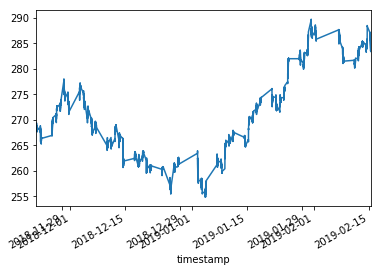

In [3]:
data['close'].plot()

## Exponential Weighted Moving Average

https://www.investopedia.com/terms/e/ema.asp


Calculating the EMA
To calculate an EMA, you must first compute the simple moving average (SMA) over a particular time period. The calculation for the SMA is straightforward: it is simply the sum of the stock's closing prices for the number of time periods in question, divided by that same number of periods. So, for example, a 20-day SMA is just the sum of the closing prices for the past 20 trading days, divided by 20.

Next, you must calculate the multiplier for smoothing (weighting) the EMA, which typically follows the formula: [2 ÷ (selected time period + 1)]. So, for a 20-day moving average, the multiplier would be [2/(20+1)]= 0.0952.

Finally, to calculate the current EMA, the following formula is used: [Closing price-EMA (previous day)] x multiplier + EMA (previous day)

내가 이해하기로는 EWMA 의 식은

$ \text{SMA}_t = \frac{\sum_{k=t-\text{n}}^t \text{value}_k}{\text{n}}$ 

$ \large \text{weight} = \frac{2}{\text{n} + 1}$

$ \text{EMA}_t = \text{SMA}_t * \text{weight} + EMA_{t-1}*(1-\text{weight}) $

인데


+ https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm/51392341#51392341
+ mlfinlab 에서 사용한 ewma 코드 출처

```python
   n = arr_in.shape[0]
    ewma = np.empty(n, dtype=float64)
    alpha = 2 / float(window + 1)
    w = 1
    ewma_old = arr_in[0]
    ewma[0] = ewma_old
    for i in range(1, n):
        w += (1-alpha)**i
        ewma_old = ewma_old*(1-alpha) + arr_in[i]
        ewma[i] = ewma_old / w
    return ewma
    
```

좀 다르다?   
```ewma_old = ewma_old*(1-alpha) + arr_in[i]   
ewma[i] = ewma_old / w```  
*TODO*   
계산해보면 같을거 같긴한데, 일단 짜보자

In [4]:
def ewma_weight(window):
    return 2/(window+1)
ewma_weight(20)

0.09523809523809523

## Unit of Bar

일단 주 단위로 구해보자

https://stackoverflow.com/questions/41625077/python-pandas-split-a-timeserie-per-month-or-week  

[Grouper](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html)

In [5]:
weekly = [g for n, g in data.groupby(pd.Grouper(level='timestamp', freq='W'))]
print(len(weekly))

13


## Tick Imbalance Bars

### step 1  
$
 b_t  = 
 \begin{cases}
 \Delta b_{t-1}  &\text{if  \( \Delta P_t = 0\)}\\
 \frac{|\Delta P_t|}{\Delta P_t} &\text{if \( \Delta P_t \neq 0 \)}
 \end{cases}
$
### step 2  
$
   \theta_T = \sum_{t = 1}^T b_t
$
 
 
현재 주 단위로 ```weekly``` 리스트에 들어있음. weekly

일단 weekly[0] 를 거르고 - 월~금이 다 있는지 장담할 수 없음 - weekly[1] 을 기준 삼아 진행해 나가자. 

일단 weekly[1] 에서 $P[b_t = 1]$ 은 구할수 있는데 문제는 $E_0[T]$ 의 설정. 일단 구하고자 하는 것은

### step 3  
$\text{arg } \text{min} \{  |\theta_t| \geq E_0[T] \mid 2P[b_t = 1] -1 \mid \} $.


인데 $ E_0[T] $를 뭘로 둘까? 

mlfinlab 에서는 

```exp_num_ticks_init=100000``` 로 해두었지만 이건 케바케가 굉장히 심한 요소.

$ E_0[T] \mid 2P[b_t = 1] -1 \mid $ 는  원래 $ E_0[T] \mid P[b_t = 1] -P[b_t = -1] \mid $ 이는
imbalance 를 측정하기 위함.  
그렇다면 t=0 를 기준으로 잡게 하는 $E_0[T]$ 를 구하면 되지 않을까? 

$|\theta_t| \geq E_0[T] \mid 2P[b_t = 1] -1 \mid$   

-> $|\theta_t| = E_0[T] \mid 2P[b_t = 1] -1 \mid$  

-> $ E_0[T] =  [ \frac{|\theta_t|}{2P[b_t = 1] -1 \mid} ]$  ??

이러면 $P[b_t=1] = 0.5$ 면 $ E_0[T] = \infty$..

첫 bar에서 $ \theta_t $ 랑 $ P[b_T= 1] $ 을 구할 수 있으니 $ = $ 이 되는 값을 $E_0[T]$ 로 두면 될 거 같은데

$\theta_t$ 의 t를 마지막 tick 으로 잡아야할까 아니면 기댓값을 써야할까?..  

imbalance 의 관점에서 생각해보자. 따라오는 bar에서 기존보다 큰 imbalance 를 감지하는 것이 목적.  

*TODO*  
$ E[\theta_t] + \sigma[\theta_t]$ : 값이 너무 크게 나옴      
$ E[\theta_t]   $ 

아 일단 그냥 $  E_0[T] = E[\theta_t] $ 로 해두자 하루종일 이거 하네

일단 $P_t$와 $\theta_t$를 구하는 부분 부터, 나중에 모듈화 해야하는 거 고려하면서 프로토타입 작성.

# TODO
인터페이스 구성 
+ Dataframe : 원하는 방향.
+ list,tuple : datafarme 에서 추출하는 대부분의 명령어들이 dataframe을 반환하지 않고 기본 데이터구조를 반환함.

웬만해서는 다 Dataframe 구조를 유지한 상태에서 진행해야 추후 데이터 조작이 편해질거 같은데,
연산은 numpy로 돌려야 빠름.  
    1. Dataframe 상태를 유지하는 연산 사용
    2. 매 연산마다 Dataframe 으로 변환. 
    3. batch 로 Dataframe 으로 변환 -> 이게 괜찮을듯. mlfinlab 도 대체로 np 로 연산하는 거 같다.

In [6]:
data.columns

Index(['close', 'volume'], dtype='object')

### Initializaiton

In [15]:
def for_init(data,value='close'):
    # target variables
    pr = 0
    e_0 =0
    # imtermediate variables
    theta = []
    
    cur_tick = 0
    
    prev_p =0
    d_p =0
    cur_p = data.iloc[0][1]
    
    prev_b =0
    cur_b =0
    cum_b=0
    
    # p[b_t = 1]
    num_tick=0 
    num_p_1 =0 
    
    for i in data.iterrows():
        # tick
        cur_tick += 1
        if(cur_tick >= threshold):
            cur_tick = 0    
            # step 1
            prev_p = cur_p
            cur_p = i[1]['close']
            d_p = cur_p - prev_p
            if d_p != 0:
                cur_b = abs(d_p)/d_p                
            else :
                if prev_b == 0 : # 예외처리
                    cur_b = 1
                else :
                    cur_b = prev_b          
            # step 2        
            cum_b += cur_b
            theta.append(cum_b )
            num_tick+=1
            if(cur_b==1):
                num_p_1 +=1
    pr = num_p_1/num_tick
    #e_0 = (np.mean(theta) + np.std(theta))/abs(2*pr - 1)
   # display(theta)
    #e_0 = (np.mean(np.abs(theta)))/abs(2*pr - 1)
    e_0 = (np.mean(np.abs(theta))) + np.std(theta)
    #e_0 = (np.mean( np.abs(theta)  )   )
    # display(theta)
    
    plt.plot(theta)
    plt.title('theta')
    return e_0,pr

6.274193548387097 0.532258064516129


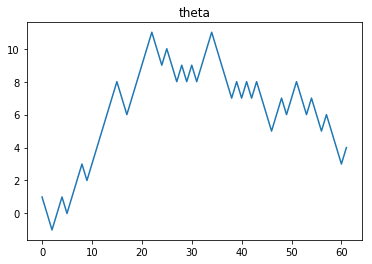

In [8]:
threshold = 1000

# init
e_0,pr =  for_init(weekly[1],threshold)  
print(str(e_0) + ' ' + str(pr))

이제는 ewma 도 고려해서, tick bar 또한 생성

mlfinlab 을 보면  

```python
# Expected number of ticks based on formed bars
                self.exp_num_ticks = ewma(np.array(
                    self.num_ticks_bar[-self.num_prev_bars:], dtype=float), self.num_prev_bars)[-1]
```

tick bar 생성시 지금까지의 tick을 가지고 새로 $E[T]$ 를 생성. 

그리고 카운터 리셋

```python
 # Reset counters
                cum_ticks, cum_volume, cum_theta = 0, 0, 0
```

TODO  
이 부분을 좀 생각해야겠다. 일단은 $\theta_t$ 를 초기화 하는 걸로 해두자.

In [9]:
weekly[1].size
tick = pd.DataFrame(columns=['close','volume']) 
tick.index.names = ['timestamp']

cnt = 0
for tmp in weekly[1].iterrows():
    print(tmp[0])
    print(tmp[1]['close'])
    cnt+=1
    if(cnt > 5):
        break

2018-11-26 09:00:00
266.94000244140625
2018-11-26 09:00:00
266.95999145507807
2018-11-26 09:00:00
266.98001098632807
2018-11-26 09:00:00
266.98001098632807
2018-11-26 09:00:00
267.0
2018-11-26 09:00:00
267.0


### Procedure

In [10]:
def for_procedure(data,e_0,pr,threshold=500,value='close'):
    # imtermediate variables
    theta = 0
    
    cur_tick = 0
    
    prev_p =0
    d_p =0
    cur_p = data.iloc[0,0]
    prev_b =0
    cur_b =0
    # p[b_t = 1]
    num_tick=0 
    num_p_1 =0 
    
    tick = pd.DataFrame(columns=['close']) 
    tick.index.names = ['timestamp']
    num_tick = 0
    
    
    for i in range(len(data.index)):
        # tick
        cur_tick += 1
        if(cur_tick >= threshold):
            cur_tick = 0
            # step 1
            prev_p = cur_p
            cur_p = data.iloc[i,0]
            d_p = cur_p - prev_p
            
            prev_b = cur_b
            if d_p != 0:
                cur_b = abs(d_p)/d_p                
            else :
                if prev_b == 0 : # 예외처리
                    cur_b = 1
                else :
                    cur_b = prev_b     
            # step 2
            theta += cur_b
            
            if(cur_b==1):
                num_p_1 +=1
            # step 3
            if(np.abs(theta) > e_0 * np.abs(2*pr - 1)):    
                tmp = data.iloc[i]           
                
                # reset 
                theta=0
                
                    #print(data.index[i])
                    #print(tmp[0])
                    #print(tmp[1])
                tick.loc[data.index[i]] = [tmp[0]] 
            num_tick+=1
        
    # update        
    weight = ewma_weight(20)
            # print('previous e_0 : ' + str(e_0) + ' | pr : ' + str(pr) )
    pr = (num_p_1/num_tick)*weight + pr*(1-weight)    
    print('tick_size ' + str(tick.size))
    e_0 = tick.size*weight + e_0*(1-weight)       
               # print('current e_0 : ' + str(e_0) + ' | pr : ' + str(pr) )
               # print('num_tick ' + str(num_tick))
               #  display(tick.head())
    return e_0,pr,tick

tick size 가 너무 큰데

4.4056635220094345 0.5
tick_size 17
5.605124138960917 0.4803921568627451
tick_size 18
6.785588506678925 0.4928415810768752
tick_size 15
7.567913410804742 0.5093963511330458
tick_size 15
8.275731181204291 0.505326857374343
tick_size 12
8.630423449661025 0.4889465217513897
tick_size 17
9.427525978264738 0.5040048362064394
tick_size 17
10.148713980334762 0.5232312663716525
tick_size 18
10.896455506017166 0.5368917806854634
tick_size 20
11.763459743539341 0.5429020872868479
tick_size 2
10.833606434630832 0.5048025687697331
tick_size 16
11.325643917046943 0.5102975622202347


Text(0.5, 1.0, 'tick')

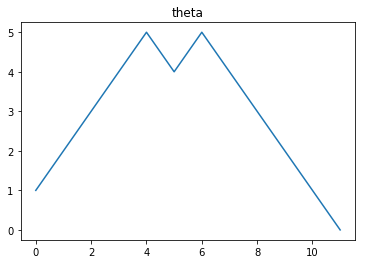

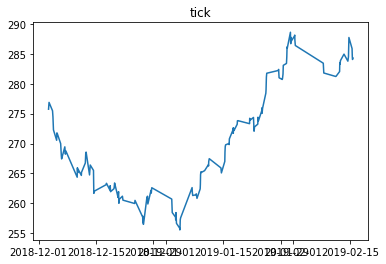

In [16]:
threshold = 5000


# init
e_0,pr =  for_init(weekly[1],threshold)  
print(str(e_0) + ' ' + str(pr))

tick = pd.DataFrame(columns=['close']) 
tick.index.names = ['timestamp']

# procedure
for tmp in weekly[2:]:
    e_0,pr,t_tick = for_procedure(tmp,e_0,pr,threshold)
    tick = pd.concat([tick, t_tick])
    #display(tick.head())
    print(str(e_0) + ' ' + str(pr))

plt.figure()
plt.plot(tick)
plt.title('tick')


잘 된건지 확인을 어떻게? 
mlfinlab 도 한번 돌려서 같이 봐보자. 

### Visualization  

https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-barplot

실제 가격변화와 tick_bar의 수를 표시해보자.  
1. 일간 데이터로 변환
2. 각 일간 tick_bar의 수를 받자.
3. 표시  

In [37]:
tick['dummy'] = 1
logic_tick = {
    'dummy'  : 'sum'
    }
tick_temp = tick.resample ('D' ).apply(logic_tick)

logic = {
    'close'  : 'last',
    }

data_day = data.resample('D').apply(logic)
data_day = data_day.dropna()
#display(data_day.head())
#display(data_day.tail())

#display(tick_temp.head())
#display(tick_temp.tail())

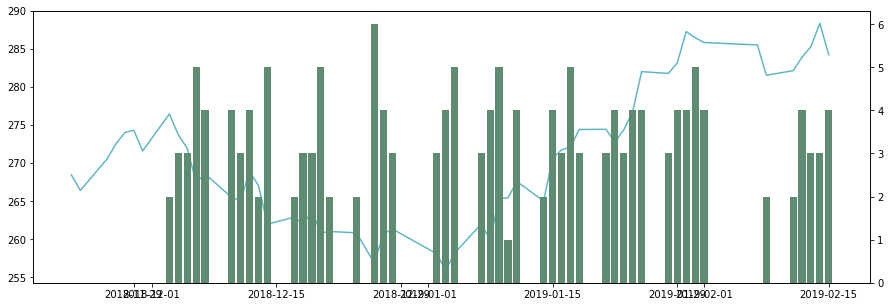

In [18]:
# https://fraserlab.com/2014/08/20/Figures-with-Python/

fig, ax1 = plt.subplots()

ax1.plot(data_day.index, data_day['close'],color='#60b6c9')
ax2 = ax1.twinx()

ax2 = ax2.bar(tick_temp.index, tick_temp['dummy'],color='#5d8c70')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

In [ ]:
for i in [10,100,1000] :
    plt.figure()
    plt.title('tick_imbalance with threshold '+ str(i))
    plt.plot(tick_bar(data,i))

### Volume Bars

In [30]:
def volume_init(data,value='volume'):
    # target variables
    pr = 0
    e_0 =0
    # imtermediate variables
    theta = []
    
    cur_tick = 0
    
    prev_p =0
    d_p =0
    cur_p = data.iloc[0][1]
    
    cur_v = 0
    cnt_v=0
    cum_v =0
    
    prev_b =0
    cur_b =0
    cum_b=0
    
    # p[b_t = 1]
    num_tick=0 
    num_p_1 =0 
    
    for i in data.iterrows():
        # volume 
        
        cur_v=i[1]['volume']
       
        cnt_v +=cur_v
        if(cnt_v >= threshold):
            cnt_v = 0    
             cum_v += cur_v
            # step 1
            prev_p = cur_p
            cur_p = i[1]['close']
            d_p = cur_p - prev_p
            
                                  
            if d_p != 0:
                cur_b = abs(d_p)/d_p                
            else :
                if prev_b == 0 : # 예외처리
                    cur_b = 1
                else :
                    cur_b = prev_b          
            # step 2        
            cum_b += cur_b * cur_v
            theta.append(cum_b )
            num_tick+=1
            if(cur_b==1):
                num_p_1 +=1
    pr = num_p_1/num_tick
    #e_0 = (np.mean(theta) + np.std(theta))/abs(2*pr - 1)
   # display(theta)
    #e_0 = (np.mean(np.abs(theta)))/abs(2*pr - 1)
    e_0 = (np.mean(np.abs(theta))) + np.std(theta)
    #e_0 = (np.mean( np.abs(theta)  )   )
    # display(theta)
    
    plt.plot(theta)
    plt.title('theta')
    return e_0,pr

80.95403956091002 0.5714285714285714


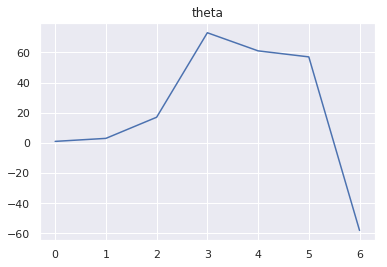

In [36]:
threshold = 45000
# init
e_0,pr =  volume_init(weekly[1],threshold)  
print(str(e_0) + ' ' + str(pr))

In [27]:
def volume_procedure(data,e_0,pr,threshold=500,value='close'):
    # imtermediate variables
    theta = 0
    
    cur_tick = 0
    
    prev_p =0
    d_p =0
    cur_p = data.iloc[0,0]
    prev_b =0
    cur_b =0
    # p[b_t = 1]
    num_tick=0 
    num_p_1 =0 
    
    tick = pd.DataFrame(columns=['close']) 
    tick.index.names = ['timestamp']
    num_tick = 0
    
    e_v=0
    v_plus=0
    
    for i in range(len(data.index)):
        # tick
        cur_tick += 1
        if(cur_tick >= threshold):
            cur_tick = 0
            # step 1
            prev_p = cur_p
            cur_p = data.iloc[i,0]
            d_p = cur_p - prev_p
            
            prev_b = cur_b
            if d_p != 0:
                cur_b = abs(d_p)/d_p                
            else :
                if prev_b == 0 : # 예외처리
                    cur_b = 1
                else :
                    cur_b = prev_b     
            # step 2
            theta += cur_b
            
            if(cur_b==1):
                num_p_1 +=1
            # step 3
            if(np.abs(theta) > e_0 * np.abs(2*pr - 1)):    
                tmp = data.iloc[i]                           
                # reset 
                theta=0                
                    #print(data.index[i])
                    #print(tmp[0])
                    #print(tmp[1])
                tick.loc[data.index[i]] = [tmp[0]] 
            num_tick+=1
        
    # update        
    weight = ewma_weight(20)
            # print('previous e_0 : ' + str(e_0) + ' | pr : ' + str(pr) )
    pr = (num_p_1/num_tick)*weight + pr*(1-weight)    
    print('tick_size ' + str(tick.size))
    e_0 = tick.size*weight + e_0*(1-weight)       
               # print('current e_0 : ' + str(e_0) + ' | pr : ' + str(pr) )
               # print('num_tick ' + str(num_tick))
               #  display(tick.head())
    return e_0,pr,tick

In [ ]:
threshold = 5000


# init
e_0,pr =  for_init(weekly[1],threshold)  
print(str(e_0) + ' ' + str(pr))

volume = pd.DataFrame(columns=['close']) 
volume.index.names = ['timestamp']

# procedure
for tmp in weekly[2:]:
    e_0,pr,t_volume = for_procedure(tmp,e_0,pr,threshold)
    volume = pd.concat([volume, t_volume])
    #display(tick.head())
    print(str(e_0) + ' ' + str(pr))

plt.figure()
plt.plot(volume)
plt.title('volume')

In [ ]:
volume['dummy'] = 1
logic_volume = {
    'dummy'  : 'sum'
    }
volume_temp = volume.resample ('D' ).apply(logic_volume)

logic = {
    'close'  : 'last',
    }

data_day = data.resample('D').apply(logic)
data_day = data_day.dropna()

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(data_day.index, data_day['close'],color='#60b6c9')
ax2 = ax1.twinx()

ax2 = ax2.bar(volume_temp.index, volume_temp['dummy'],color='#5d8c70')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

### Run Bars

### CUSUM Filter

## Distribution

https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3/51742444

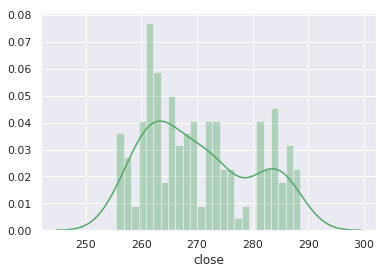

In [35]:
fig, ax = plt.subplots()
sns.distplot(tick['close'], bins=25, color="g", ax=ax)
plt.show()